# Preprocessing

Import Library

In [1]:
pip install emoji

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import joblib
import emoji
import random
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
print(nltk.data.path)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# menetapkan random supaya hasil tidak acak
random.seed(42)
np.random.seed(42)

Load Data

In [5]:
# Membaca file dengan nama spesifik
df = pd.read_csv("data.csv")
df

,Ulasan
0,bahan botol tipis. setauku pet 1 hanya diguna...
1,"Materialnya bagus, tahan lama, ga gampang rusa..."
2,packing aman ya dan botol ada plastik pembungk...
3,kualitas top. model easy grip sangat OK. packi...
4,Kaget pas datang paketnya dalam dus gede bange...
...,...
10271,baguss banget botolnyaMaterial Produk Bagus. W...
10272,Alhamdulillah....dpt gratisan lock n lock........
10273,Barang ok sesuai harga packing kurang rapi
10274,Bagus banget barangnyaaa .. kualitas oke juga


In [6]:
# Menampilkan data duplikat
df[df.duplicated()]


,Ulasan


- Ganti kata slang dengan kata baku
- hapus Kata tidak relevan
- Mengubah huruf menjadi huruf kecil
- hapus angka
- hapus tanda baca
- cleaning data

In [7]:
# Kamus penggantian kata-kata slang menjadi baku dan penggantian kata bahsa inggris menjadi indonesia
custom_dict = {
    'mantap': ['mantep'],
    'bagus' : ['good', 'top'],
    'tidak': ['ga', 'gak'],
    'oke' : ['ok'],
    'mudah': ['easy'],
    'besar': ['gede'],
    'kukuh': ['kokoh'],
    'senang' :['happy'],
    'saran' : ['rekomen', 'recommended'],
    'pas' : ['sesuai'],
    'sepadan' :['worth it'],
    'terlambat' : ['telat'],
    'kotor' : ['jorok'],
    'menunda' :['delay'],
    'melentur' : ['melenyot']
}

# Daftar kata-kata tidak relevan yang ingin dihapus
irrelevant_words = ['yang', 'barang', 'nya', 'botol', 'air', 'ini', 'itu']

# Persiapan stopwords
stop_words = set(stopwords.words('indonesian'))


def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')  # Menghapus semua emoji

# Fungsi untuk membersihkan teks dan mengganti kata slang menjadi baku
def clean_text(text):
    text = text.lower()  # Lowercase semua teks
    text = remove_emoji(text)  # Hapus emoji di sini
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca

    # Gantikan kata slang dengan kata baku berdasarkan custom_dict
    for key, replacements in custom_dict.items():
        for word in replacements:
            # Gunakan regex untuk memastikan penggantian hanya dilakukan pada kata yang terpisah
            text = re.sub(r'\b' + re.escape(word) + r'\b', key, text)

    tokens = word_tokenize(text)  # Tokenisasi teks
    tokens = [word for word in tokens if word not in stop_words]  # Menghapus stopwords
    tokens = [word for word in tokens if word not in irrelevant_words]  # Menghapus kata irrelevan
    tokens = list(dict.fromkeys(tokens))  # Menghapus duplikasi dengan mengubah ke set dan kembali ke list
    return ' '.join(tokens)  # Gabungkan kembali token menjadi kalimat



# Terapkan fungsi untuk membersihkan teks di kolom 'Ulasan'
df['Cleaned'] = df['Ulasan'].apply(clean_text)

In [8]:
# Menampilkan hasil ulasan dan cleaned
df[['Ulasan', 'Cleaned']]

,Ulasan,Cleaned
0,bahan botol tipis. setauku pet 1 hanya diguna...,bahan tipis setauku pet pakai tp yg beda
1,"Materialnya bagus, tahan lama, ga gampang rusa...",materialnya bagus tahan gampang rusak awet
2,packing aman ya dan botol ada plastik pembungk...,packing aman ya plastik pembungkusnya tdk gore...
3,kualitas top. model easy grip sangat OK. packi...,kualitas bagus model mudah grip oke packing su...
4,Kaget pas datang paketnya dalam dus gede bange...,kaget pas paketnya dus banget aman pokoknya la...
...,...,...
10271,baguss banget botolnyaMaterial Produk Bagus. W...,baguss banget botolnyamaterial produk bagus wa...
10272,Alhamdulillah....dpt gratisan lock n lock........,alhamdulillahdpt gratisan lock n lockbener² ru...
10273,Barang ok sesuai harga packing kurang rapi,oke pas harga packing rapi
10274,Bagus banget barangnyaaa .. kualitas oke juga,bagus banget barangnyaaa kualitas oke


Bersihkan Duplikat

In [9]:
# Menampilkan data duplikat di data cleaned
duplikat = df['Cleaned'][df['Cleaned'].duplicated()]
duplikat

,Cleaned
200,material produk bagus kualitas warna pas ukuran
221,material produk bagus kualitas ukuran pas warna
236,material produk bagus kualitas warna pas ukuran
266,material produk bagus kualitas warna pas ukuran
305,material produk bagus warna pas kualitas ukuran
...,...
9901,kualitas bagus
10006,kualitas produk bagus warna pas ukuran
10130,pengiriman cepat barangnya bagus
10160,material produk bagus ukuran pas warna kualitas


In [10]:
# Menghapus duplikat berdasarkan kolom 'Cleaned'
df = df.drop_duplicates(subset='Cleaned', keep='first').reset_index(drop=True)

# Menampilkan hasil sesudah duplikat dihapus
df['Cleaned']

,Cleaned
0,bahan tipis setauku pet pakai tp yg beda
1,materialnya bagus tahan gampang rusak awet
2,packing aman ya plastik pembungkusnya tdk gore...
3,kualitas bagus model mudah grip oke packing su...
4,kaget pas paketnya dus banget aman pokoknya la...
...,...
9996,baguss banget botolnyamaterial produk bagus wa...
9997,alhamdulillahdpt gratisan lock n lockbener² ru...
9998,oke pas harga packing rapi
9999,bagus banget barangnyaaa kualitas oke


# Labeling

Labeling Lexicon
- Positif > Negatif : Kelas Positif
- Positif < Negatif : Kelas Negatif
- Positif = Negatif : Kelas Netral

In [11]:
# Load lexicon
df_positif = pd.read_csv("positif.csv", sep=";")
df_negatif = pd.read_csv("negatif.csv", sep=";")

df_positif.columns = df_positif.columns.str.strip().str.lower()
df_negatif.columns = df_negatif.columns.str.strip().str.lower()

df_positif['weight'] = df_positif['weight'].astype(int)
df_negatif['weight'] = df_negatif['weight'].astype(int)

# Gabungkan ke dictionary, tanpa menimpa nilai positif jika ada duplikat
lexicon_dict = {}

# Tambahkan kata dari lexicon positif
for _, row in df_positif.iterrows():
    lexicon_dict[row['word']] = row['weight']

# Tambahkan kata dari lexicon negatif jika belum ada di positif
for _, row in df_negatif.iterrows():
    if row['word'] not in lexicon_dict:
        lexicon_dict[row['word']] = -abs(row['weight'])

# Fungsi debug dengan detail skor
def assign_sentiment_score_debug(text):
    text = text.lower()
    tokens = text.split()  # tokenisasi sederhana
    score = 0
    details = []

    for token in tokens:
        weight = lexicon_dict.get(token)
        if weight is not None:
            score += weight
            details.append((token, weight))

    print(f"\nKalimat: {text}")
    print(f"Token ditemukan: {details}")
    print(f"Skor akhir: {score}")

    if score > 0:
        return "Positif"
    elif score < 0:
        return "Negatif"
    else:
        return "Netral"

In [12]:
# Terapkan fungsi scoring ke kolom cleaned
df['Label'] = df['Cleaned'].apply(assign_sentiment_score_debug)

Streaming output truncated to the last 5000 lines.

Kalimat: suami suka banget botolnya ramping pdhl isinya
Token ditemukan: [('suka', 3), ('banget', 1)]
Skor akhir: 4

Kalimat: bahannya pas deskripsi bagus banget
Token ditemukan: [('pas', 3), ('deskripsi', -4), ('bagus', 2), ('banget', 1)]
Skor akhir: 2

Kalimat: kebeli koleksi tumbler one piece suka bangetttt pokoknya kerenlah locknlock
Token ditemukan: [('koleksi', 1), ('suka', 3), ('pokoknya', -3)]
Skor akhir: 1

Kalimat: sampe bagus sih pas harga
Token ditemukan: [('bagus', 2), ('pas', 3), ('harga', 3)]
Skor akhir: 8

Kalimat: kualitas bagus print timbul gituu
Token ditemukan: [('kualitas', 4), ('bagus', 2), ('timbul', -3)]
Skor akhir: 3

Kalimat: cepet bgt sampenya minggu order senin udh sampe tumblernya lucu blm dicoba sih semoga awet
Token ditemukan: [('cepet', 2), ('lucu', 3), ('dicoba', 2), ('awet', 4)]
Skor akhir: 11

Kalimat: huaaaaa bagus banget lupy udh ngankring aja manis
Token ditemukan: [('bagus', 2), ('banget', 1), ('

In [13]:
# Baru tampilkan hasil
df[['Cleaned', 'Label']]

,Cleaned,Label
0,bahan tipis setauku pet pakai tp yg beda,Negatif
1,materialnya bagus tahan gampang rusak awet,Positif
2,packing aman ya plastik pembungkusnya tdk gore...,Positif
3,kualitas bagus model mudah grip oke packing su...,Positif
4,kaget pas paketnya dus banget aman pokoknya la...,Positif
...,...,...
9996,baguss banget botolnyamaterial produk bagus wa...,Positif
9997,alhamdulillahdpt gratisan lock n lockbener² ru...,Positif
9998,oke pas harga packing rapi,Positif
9999,bagus banget barangnyaaa kualitas oke,Positif


In [14]:
positif_data = df[df['Label'] == 'Positif'][['Cleaned', 'Label']]
positif_data

,Cleaned,Label
1,materialnya bagus tahan gampang rusak awet,Positif
2,packing aman ya plastik pembungkusnya tdk gore...,Positif
3,kualitas bagus model mudah grip oke packing su...,Positif
4,kaget pas paketnya dus banget aman pokoknya la...,Positif
5,tokped disuruh konsumptif ngasih case back per...,Positif
...,...,...
9996,baguss banget botolnyamaterial produk bagus wa...,Positif
9997,alhamdulillahdpt gratisan lock n lockbener² ru...,Positif
9998,oke pas harga packing rapi,Positif
9999,bagus banget barangnyaaa kualitas oke,Positif


In [15]:
# Menampilkan hanya kolom 'Cleaned' dan 'Label' untuk kelas negatif
negatif_data = df[df['Label'] == 'Negatif'][['Cleaned', 'Label']]
negatif_data

,Cleaned,Label
0,bahan tipis setauku pet pakai tp yg beda,Negatif
17,minum jenis pet dipamai,Negatif
19,bagus bening ukuran bagusss warna cakepppp mantul,Negatif
21,mantab container water bottle pembelian ketiga...,Negatif
34,penjual responsif packaging rapi bubble wrap k...,Negatif
...,...,...
9964,tutup rapat,Negatif
9969,pet cuman dipakainy sharusny ditulis deskripsi...,Negatif
9979,pengiriman nol rupiah original cepat,Negatif
9981,pengiriman cepat packing aman kardus bubble warp,Negatif


In [16]:
# Menampilkan hanya kolom 'Cleaned' dan 'Label' untuk kelas Positif
netral_data = df[df['Label'] == 'Netral'][['Cleaned', 'Label']]
netral_data

,Cleaned,Label
11,produk pesanan pas pengiriman standard dipake ...,Netral
50,barangnya diterima kondisi kardus pengiriman p...,Netral
88,pas gambar deskripsi proses pengiriman cepat p...,Netral
102,baguspacking aman bubble wrap plastic tebal,Netral
132,kirain merk lock and bagus plastiknya pet,Netral
...,...,...
9869,packaging aman fast delivery,Netral
9870,pas deskripsi pengiriman cepat aman sayang pen...,Netral
9891,ori diragukan kualitasnya,Netral
9957,bagus cm krn co buru jd salah pilih syg blm dp...,Netral


In [17]:
# Jumlah Distribusi Sentimen
# Menghitung jumlah masing-masing label
label_counts = df['Label'].value_counts()
label_counts

,count
Label,
Positif,8309
Negatif,1037
Netral,655


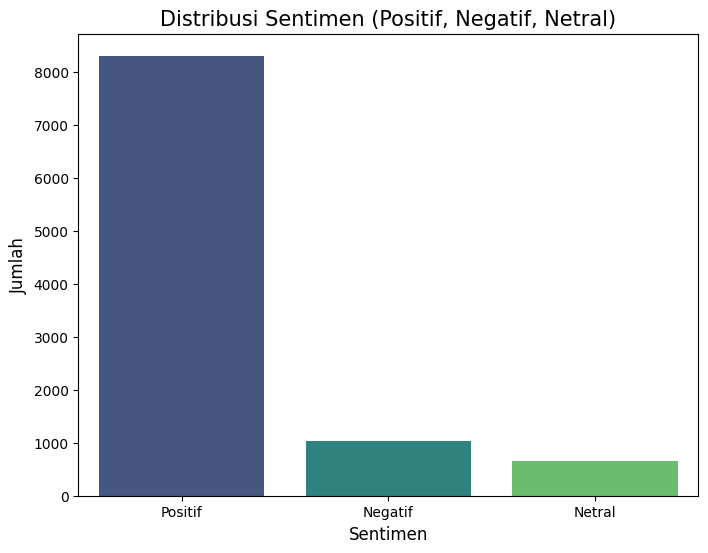

In [18]:
# Membuat bar plot untuk distribusi sentimen
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', hue=label_counts.index, dodge=False)  # Set hue and dodge

# Menambahkan judul dan label
plt.title('Distribusi Sentimen (Positif, Negatif, Netral)', fontsize=15)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.legend([],[],frameon=False) # Remove the legend

# Menampilkan plot
plt.show()

Visualisasi Word Cloud

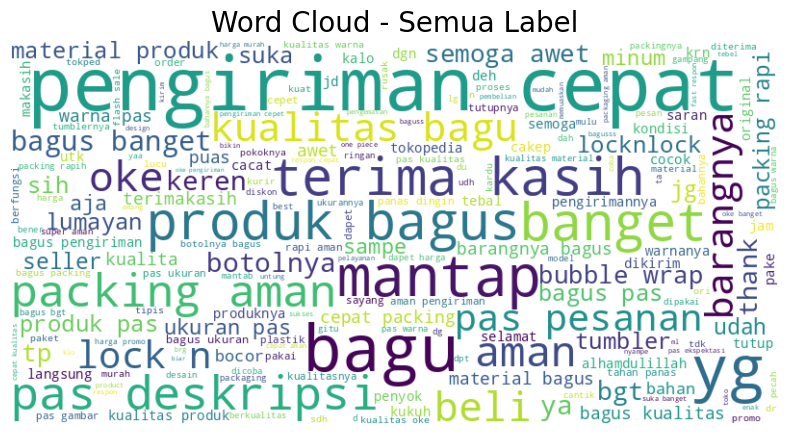

In [19]:
all_text = ' '.join(df['Cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Semua Label', fontsize=20)
plt.axis('off')
plt.show()

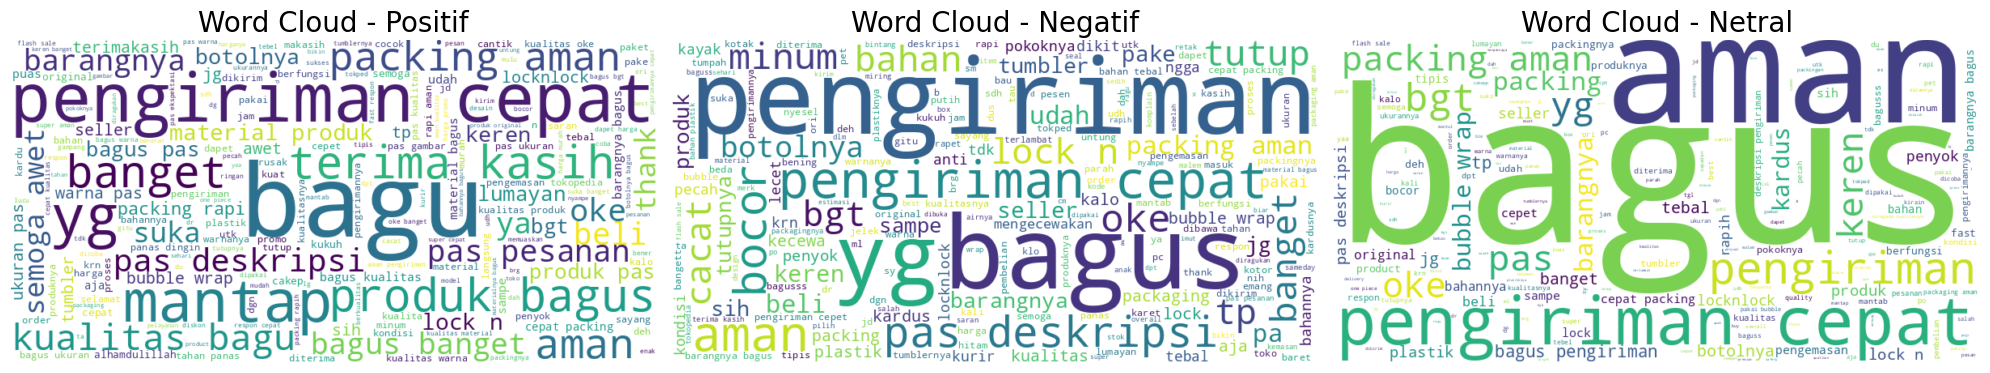

In [20]:
def generate_wordcloud_from_label(df, label, ax):

    filtered_df = df[df['Label'] == label]
    text = ' '.join(filtered_df['Cleaned'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud - {label}', fontsize=20)
    ax.axis('off')

# Buat figure dan axis untuk 3 label
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Panggil fungsi untuk setiap label
generate_wordcloud_from_label(df, 'Positif', axes[0])
generate_wordcloud_from_label(df, 'Negatif', axes[1])
generate_wordcloud_from_label(df, 'Netral', axes[2])

plt.tight_layout()
plt.show()


# Ekstraksi Fitur

Pisah variabel X dan y

In [21]:
# Menyusun X dan y
X = df['Cleaned']  # Fitur dari kolom 'Cleaned'
y = df['Label']  # Target dari kolom 'Label'

In [22]:
# Menggunakan TfidfVectorizer untuk ekstraksi fitur
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [23]:
# Visualisasi TF-IDF
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Gabungkan dengan label
df_tfidf = pd.concat([X_tfidf_df, y], axis=1)

# Tampilkan hasilnya
df_tfidf

,aa,aaaa,aaaaa,aaaaaa,aaaaaaaa,aaaaah,aaaah,aah,aamiiiin,aamiin,...,𝚐𝚘𝚘,𝚓𝚍,𝚔𝚊𝚛𝚍𝚞𝚜,𝚙𝚊𝚔𝚊𝚒,𝚛𝚞𝚜𝚊𝚔,𝚜𝚊𝚖𝚙𝚊𝚒,𝚜𝚎𝚕𝚊𝚖𝚊𝚝,𝚝𝚊𝚗𝚙𝚊,𝚝𝚘𝚙𝚕𝚎𝚜𝚗𝚢𝚊,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negatif
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif
9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positif


SMOTE Oversampling untuk mengatasi data yang tidak seimbang

In [24]:
# Terapkan SMOTE untuk oversampling setelah TF-IDF
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

In [25]:
# Cek distribusi label setelah SMOTE
# Menghitung jumlah masing-masing label setelah SMOTE
label_counts_smote = pd.Series(y_smote).value_counts()
label_counts_smote

,count
Label,
Negatif,8309
Positif,8309
Netral,8309


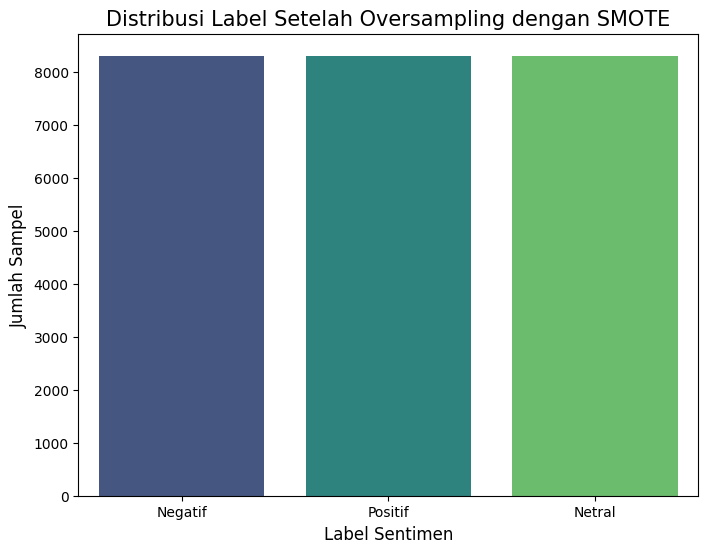

In [26]:
# Membuat bar plot untuk distribusi label setelah oversampling
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts_smote.index, y=label_counts_smote.values, palette='viridis', hue=label_counts_smote.index, dodge=False)

# Menambahkan judul dan label
plt.title('Distribusi Label Setelah Oversampling dengan SMOTE', fontsize=15)
plt.xlabel('Label Sentimen', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.legend([],[],frameon=False) # Remove the legend

# Menampilkan plot
plt.show()

In [27]:
# Label Encoding untuk y_resampled
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_smote)

In [28]:
# Buat DataFrame mapping label ke angka
label_mapping_df = pd.DataFrame({
    'Label': encoder.classes_,
    'Encoding': range(len(encoder.classes_))
})

# Tampilkan
label_mapping_df

,Label,Encoding
0,Negatif,0
1,Netral,1
2,Positif,2


In [29]:
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_encoded, random_state=42, stratify=y_encoded)

# Modeling

# Evaluation

In [30]:
# Membuat dan melatih model SVM
model = SVC(random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [31]:
# Prediksi Neural Network pada data uji
y_pred = model.predict(X_test)

In [32]:
# Evaluasi model Neural Network
print("\n=== Evaluasi Model ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


=== Evaluasi Model ===
Confusion Matrix:
 [[2038    0   39]
 [   1 2043   33]
 [   6    6 2066]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2077
           1       1.00      0.98      0.99      2077
           2       0.97      0.99      0.98      2078

    accuracy                           0.99      6232
   macro avg       0.99      0.99      0.99      6232
weighted avg       0.99      0.99      0.99      6232



In [33]:
joblib.dump(model, 'model.pkl')
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']